In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=224d805531224f9d2cb17e3ac7b624ccecec32769cdac2990f31b8d734f9ad44
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
!pip install torch_optimizer

     |████████████████████████████████| 61kB 5.7MB/s 


- 코랩 세션 자동연결 콘솔코드
- https://bryan7.tistory.com/1077

In [ ]:
import os
import gc
gc.enable()
import sys
import math
import json
import time
import random
from glob import glob
from datetime import datetime

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import multiprocessing
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
from torch import Tensor
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.optim import lr_scheduler, Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
# import efficientnet_pytorch

import torch_optimizer as optim
import albumentations as A

import sklearn

import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 17 15:12:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# IN_KERNEL = os.environ.get('KAGGLE_WORKING_DIR') is not None
# MIN_SAMPLES_PER_CLASS = 10
# BATCH_SIZE = 12
# NUM_WORKERS =1 #multiprocessing.cpu_count()
# MAX_STEPS_PER_EPOCH = 15000
# NUM_EPOCHS = 20
# LOG_FREQ = 10
# NUM_TOP_PREDICTS = 1 # top k??: 마지막 벡터 = class 가장 높은 confidence 값을 가진 클래스를 어떤 것으로 할지

#####
torch.cuda.empty_cache()

IN_KERNEL = os.environ.get('KAGGLE_WORKING_DIR') is not None
MIN_SAMPLES_PER_CLASS = 10
BATCH_SIZE = 36 # 36
#BATCH_SIZE = 1
#NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 0
print(NUM_WORKERS)
MAX_STEPS_PER_EPOCH = 15000
NUM_EPOCHS = 1 # 50
LOG_FREQ = 100
NUM_TOP_PREDICTS = 1
ENABLE_FAST_SKIP = True


0


In [ ]:
train = pd.read_csv('/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/train.csv')
test = pd.read_csv('/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/sample_submisstion.csv')
train_dir = '/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/train_dataset/'
test_dir = '/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/test_dataset/'
model_path = '/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/model_201114.pth'

# Dataset 정의

In [ ]:
# class ImageDataset(torch.utils.data.Dataset):
#     # 해당 코드는 변경할 필요가 없음
#     def __init__(self, dataframe: pd.DataFrame, image_dir:str, mode: str):
#         self.df = dataframe
#         self.mode = mode
#         self.image_dir = image_dir
        
#         transforms_list = []
#         if self.mode == 'train':
#             # Increase image size from (64,64) to higher resolution,
#             # Make sure to change in RandomResizedCrop as well.
#             transforms_list = [
#                 transforms.Resize((64,64)),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomChoice([
#                     transforms.RandomResizedCrop(64),
#                     transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#                     transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
#                                             scale=(0.8, 1.2), shear=15,
#                                             resample=Image.BILINEAR)
#                 ]),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                       std=[0.229, 0.224, 0.225]),
#             ]
#         else:
#             transforms_list.extend([
#                 # Keep this resize same as train
#                 transforms.Resize((64,64)),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                       std=[0.229, 0.224, 0.225]),
#             ])
#         self.transforms = transforms.Compose(transforms_list)

#     def __getitem__(self, index: int):
#         # 데이터에서 이미지 정의하는 부분

#         # 이미지 이름
#         image_id = self.df.iloc[index].id
#         # 해당 이미지가 들어 있는 폴더 이름
#         #image_folder = ' '.join(self.df['id'].iloc[index].split('_')[:-1])
#         image_path = f"{self.image_dir}/{image_id}.JPG"

#         image = Image.open(image_path)
#         image = self.transforms(image)

#         if self.mode == 'test':
#             return {'image':image}
#         else:
#             image_plt = mpimg.imread(image_path)
#             plt.axis("off")
#             plt.imshow(image_plt)
#             plt.show()
#             print(f"class : {self.df.iloc[index].landmark_id}")
#             return {'image':image, 
#                     'target':self.df.iloc[index].landmark_id}

#     def __len__(self) -> int:
#         return self.df.shape[0]


###########
IMG_SIZE = 224

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, image_dir:str, mode: str):
        self.df = dataframe
        self.mode = mode
        self.image_dir = image_dir
        print(f"self.image_dir : {image_dir}")
        
        transforms_list = []
        if self.mode == 'train':
            # Increase image size from (64,64) to higher resolution,
            # Make sure to change in RandomResizedCrop as well.
            transforms_list = [
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomResizedCrop(IMG_SIZE),
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ]),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                #                      std=[0.229, 0.224, 0.225]),
                transforms.Normalize(mean=[0.4452, 0.4457, 0.4464],
                                      std=[0.2592, 0.2596, 0.2600]),
            ]
        else:
            transforms_list.extend([
                # Keep this resize same as train
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                #                      std=[0.229, 0.224, 0.225]),
                transforms.Normalize(mean=[0.4452, 0.4457, 0.4464],
                                      std=[0.2592, 0.2596, 0.2600]),
            ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index: int):
        image_id = self.df.iloc[index].id
        #image_path = f"{self.image_dir}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg"
        image_path = f"{self.image_dir}{image_id}.JPG"
        image = Image.open(image_path)
        image = self.transforms(image)

        if self.mode == 'test':
            return {'image':image}
        else:
            #import matplotlib.image as mpimg
            #image_plt = mpimg.imread(image_path)
            #plt.axis("off")
            #plt.imshow(image_plt)
            #plt.show()
            #print(f"class : {self.df.iloc[index].landmark_id}")
            return {'image':image, 
                    'target':self.df.iloc[index].landmark_id}

    def __len__(self) -> int:
        return self.df.shape[0]
    
    
# class LandmarkDataset(Dataset):
#     def __init__(self, mode: str = 'train', transforms: transforms = None):
#         self.mode = mode
#         self.image_ids = glob.glob(f'./data/{mode}/**/**/*')
#         if self.mode == 'train':
#             with open('./data/train.csv') as f:
#                 labels = list(csv.reader(f))[1:]
#                 self.labels = {label[0]: int(label[1]) for label in labels}

#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_ids)

#     def __getitem__(self, index: int) -> Tuple[Tensor]:
#         image = Image.open(self.image_ids[index]).convert('RGB')
#         image_id = os.path.splitext(os.path.basename(self.image_ids[index]))[0]
#         if self.transforms is not None:
#             image = self.transforms(image)
        
#         if self.mode == 'train':
#             label = self.labels[image_id]
#             return image, label
#         else:
#             return image_id, image

In [ ]:
image_id = train.iloc[2].id
image_path = f"{train_dir}{image_id}.JPG"

In [ ]:
temp_ls = os.listdir(train_dir)

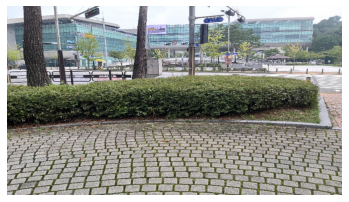

class : 114


In [ ]:
image_plt = mpimg.imread(image_path)
plt.axis("off")
plt.imshow(image_plt)
plt.show()
print(f"class : {train.iloc[0].landmark_id}")

# Data loader

In [ ]:
# def load_data(train, train_dir): #test,test_dir
#     counts = train.landmark_id.value_counts()
#     print(counts)
#     selected_classes = counts[counts >= MIN_SAMPLES_PER_CLASS].index
#     num_classes = selected_classes.shape[0]
#     print('classes with at least N samples:', num_classes)

#     train = train.loc[train.landmark_id.isin(selected_classes)]
#     print('train_df', train.shape)
#     # print('test_df', test.shape)

#     # filter non-existing test images
#     # exists = lambda img: os.path.exists(f'{test_dir}/{img[0]}/{img[1]}/{img[2]}/{img}.jpg')
#     # test = test.loc[test.id.apply(exists)]
#     # print('test_df after filtering', test.shape)

#     label_encoder = LabelEncoder()
#     label_encoder.fit(train.landmark_id.values)
#     print('found classes', len(label_encoder.classes_))
#     assert len(label_encoder.classes_) == num_classes

#     train.landmark_id = label_encoder.transform(train.landmark_id)

#     train_dataset = ImageDataset(train, train_dir, mode='train')
#     # test_dataset = ImageDataset(test, test_dir, mode='test')

#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                               shuffle=False, num_workers=4, drop_last=True)

#     # test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#     #                          shuffle=False, num_workers=NUM_WORKERS)

#     return train_loader, label_encoder, num_classes # ,test_loader

#####################
def load_data(train, test, train_dir, test_dir):
    counts = train.landmark_id.value_counts()
    selected_classes = counts[counts >= MIN_SAMPLES_PER_CLASS].index
    num_classes = selected_classes.shape[0]
    print('classes with at least N samples:', num_classes)

    train = train.loc[train.landmark_id.isin(selected_classes)]
    print('train_df', train.shape)
    print('test_df', test.shape)

    # filter non-existing test images
    #exists = lambda img: os.path.exists(f'{test_dir}/{img[0]}/{img[1]}/{img[2]}/{img}.jpg')
    exists = lambda img: os.path.exists(f'{test_dir}/{img}.JPG')
    test = test.loc[test.id.apply(exists)]
    print('test_df after filtering', test.shape)

    label_encoder = LabelEncoder()
    label_encoder.fit(train.landmark_id.values)
    print('found classes', len(label_encoder.classes_))
    assert len(label_encoder.classes_) == num_classes

    train.landmark_id = label_encoder.transform(train.landmark_id)

    train_dataset = ImageDataset(train, train_dir, mode='train')
    test_dataset = ImageDataset(test, test_dir, mode='test')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=NUM_WORKERS)

    return train_loader, test_loader, label_encoder, num_classes

# Optimizer

In [ ]:
# def radam(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
#     if isinstance(betas, str):
#         betas = eval(betas)
#     return optim.RAdam(parameters,
#                       lr=lr,
#                       betas=betas,
#                       eps=eps,
#                       weight_decay=weight_decay)

def adam(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
    if isinstance(betas, str):
        betas = eval(betas)
    return Adam(parameters,
                lr=lr,
                betas=betas,
                eps=eps,
                weight_decay=weight_decay)

# Metrics

In [ ]:

# class AverageMeter:
#     ''' Computes and stores the average and current value '''
#     def __init__(self) -> None:
#         self.reset()

#     def reset(self) -> None:
#         self.val = 0.0
#         self.avg = 0.0
#         self.sum = 0.0
#         self.count = 0

#     def update(self, val: float, n: int = 1) -> None:
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count


class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
#     ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
#     assert len(predicts.shape) == 1
#     assert len(confs.shape) == 1
#     assert len(targets.shape) == 1
#     assert predicts.shape == confs.shape and confs.shape == targets.shape

#     _, indices = torch.sort(confs, descending=True)

#     confs = confs.cpu().numpy()
#     predicts = predicts[indices].cpu().numpy()
#     targets = targets[indices].cpu().numpy()

#     res, true_pos = 0.0, 0

#     for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
#         rel = int(p == t)
#         true_pos += rel

#         res += true_pos / (i + 1) * rel

#     res /= targets.shape[0] # FIXME: incorrect, not all test images depict landmarks
#     return res

####
def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0] # FIXME: incorrect, not all test images depict landmarks
    return res

# Modeling

In [ ]:
# class EfficientNetEncoderHead(nn.Module):
#     def __init__(self, depth, num_classes):
#         super(EfficientNetEncoderHead, self).__init__()
#         self.depth = depth
#         self.base = efficientnet_pytorch.EfficientNet.from_pretrained(f'efficientnet-b{self.depth}')
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.output_filter = self.base._fc.in_features
#         self.classifier = nn.Linear(self.output_filter, num_classes)
#     def forward(self, x):
#         x = self.base.extract_features(x)
#         x = self.avg_pool(x).squeeze(-1).squeeze(-1)
#         x = self.classifier(x)
#         return x

####

# class EfficientNetEncoderHead(nn.Module):
#     def __init__(self, depth, num_classes):
#         super(EfficientNetEncoderHead, self).__init__()
#         self.depth = depth
#         self.base = efficientnet_pytorch.EfficientNet.from_name(f'efficientnet-b{self.depth}')
#         # pretrained_file = glob(f'../dataset/pretrained/efficientnet-b{self.depth}*')[0]
#         # pretrained_file = efficientnet_pytorch.EfficientNet.from_pretrained(f'efficientnet-b{self.depth}')
#         # self.base.load_state_dict(torch.load(pretrained_file))
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.output_filter = self.base._fc.in_features
#         self.classifier = nn.Linear(self.output_filter, num_classes)
#     def forward(self, x):
#         x = self.base.extract_features(x)
#         x = self.avg_pool(x).squeeze(-1).squeeze(-1)
#         x = self.classifier(x)
#         return x

# Efficient Net을 불러와서 적용 

class EfficientNetEncoderHead(nn.Module):
    def __init__(self, depth, num_classes):
        super(EfficientNetEncoderHead, self).__init__()
        self.depth = depth
        self.base = EfficientNet.from_pretrained(f'efficientnet-b{self.depth}')
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.output_filter = self.base._fc.in_features
        self.classifier = nn.Linear(self.output_filter, num_classes)
        
    def forward(self, x):
        x = self.base.extract_features(x)
        x = self.avg_pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x

# training

In [ ]:
# def train_step(train_loader, 
#           model, 
#           criterion, 
#           optimizer,
#           epoch, 
#           lr_scheduler):
#     print(f'epoch {epoch}')
#     batch_time = AverageMeter()
#     losses = AverageMeter()
#     avg_score = AverageMeter()

#     model.train()
#     num_steps = min(len(train_loader), MAX_STEPS_PER_EPOCH)

#     print(f'total batches: {num_steps}')

#     end = time.time()
#     lr = None

#     for i, data in enumerate(train_loader):
#         input_ = data['image']
#         target = data['target']
#         batch_size, _, _, _ = input_.shape
        
#         output = model(input_.cuda())
#         loss = criterion(output, target.cuda())
#         confs, predicts = torch.max(output.detach(), dim=1)
#         avg_score.update(GAP(predicts, confs, target))
#         losses.update(loss.data.item(), input_.size(0))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         lr = optimizer.param_groups[0]['lr']
        
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if i % LOG_FREQ == 0:
#             print(f'{epoch} [{i}/{num_steps}]\t'
#                     f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#                     f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
#                     f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
#                     + str(lr))

#     print(f' * average GAP on train {avg_score.avg:.4f}')



def train_step(train_loader, 
          model, 
          criterion, 
          optimizer,
          epoch, 
          lr_scheduler):
    print(f'epoch {epoch}')
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = min(len(train_loader), MAX_STEPS_PER_EPOCH)

    print(f'total batches: {num_steps}')

    end = time.time()
    lr = None

    for i, data in enumerate(train_loader):
        input_ = data['image']
        target = data['target']
        batch_size, _, _, _ = input_.shape
        
        output = model(input_.cuda())
        loss = criterion(output, target.cuda())
        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))
        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lr_scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        #lr_scheduler.step(loss) # !! 
        
        batch_time.update(time.time() - end)
        end = time.time()

        if i % LOG_FREQ == 0:
            print(f'[EPOCH {epoch}] [{i}/{num_steps}]\t'
                    f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                    f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                    + str(lr))

    #torch.save(model.cpu().state_dict(), model_path)        
    print(f' * average GAP on train {avg_score.avg:.4f}')

# inference

In [ ]:
# def inference(data_loader, model):
#     model.eval()

#     activation = nn.Softmax(dim=1)
#     all_predicts, all_confs, all_targets = [], [], []

#     with torch.no_grad():
#         for i, data in enumerate(tqdm(data_loader, disable=IN_KERNEL)):
#             if data_loader.dataset.mode != 'test':
#                 input_, target = data['image'], data['target']
#             else:
#                 input_, target = data['image'], None

#             output = model(input_.cuda())
#             output = activation(output)

#             confs, predicts = torch.topk(output, NUM_TOP_PREDICTS)
#             all_confs.append(confs)
#             all_predicts.append(predicts)

#             if target is not None:
#                 all_targets.append(target)

#     predicts = torch.cat(all_predicts)
#     confs = torch.cat(all_confs)
#     targets = torch.cat(all_targets) if len(all_targets) else None

#     return predicts, confs, targets


def inference(data_loader, model):
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, disable=IN_KERNEL)):
            if data_loader.dataset.mode != 'test':
                input_, target = data['image'], data['target']
            else:
                input_, target = data['image'], None

            output = model(input_.cuda())
            output = activation(output)

            confs, predicts = torch.topk(output, NUM_TOP_PREDICTS)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

# process

In [ ]:
global_start_time = time.time()
train_loader, label_encoder, num_classes = load_data(
    train, train_dir
) # test_loader, test , test_dir

classes with at least N samples: 1049
train_df (88102, 2)
found classes 1049
self.image_dir : /content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/train_dataset/


In [ ]:
# model = EfficientNetEncoderHead(depth=0, num_classes=num_classes)
model = EfficientNetEncoderHead(depth=0, num_classes=num_classes)
model.cuda()

In [ ]:
# criterion = nn.CrossEntropyLoss()

# optimizer = radam(model.parameters(), lr=1e-3, betas=(0.9,0.999), eps=1e-3, weight_decay=1e-4)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*NUM_EPOCHS, eta_min=1e-6)

# for epoch in range(1, NUM_EPOCHS + 1):
#     print('-' * 50)
#     train_step(train_loader, model, criterion, optimizer, epoch, scheduler)

criterion = nn.CrossEntropyLoss()

optimizer = adam(model.parameters(), lr=1e-3, betas=(0.9,0.999), eps=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*NUM_EPOCHS, eta_min=1e-6)

# 원하는 에폭마다, 이전 학습률 대비 변경폭에 따라 학습률을 감소시켜주는 방식
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9, threshold=1,patience=1, verbose=1, mode='min', min-delta=0.0001)

for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 50)
    train_step(train_loader, model, criterion, optimizer, epoch, scheduler)
    # print("[SAVE MODEL]")
    # torch.save(model.cpu().state_dict(), model_path+str(epoch))
    # model.cuda()

# generation

In [ ]:
def generate_submission(test_loader, model, label_encoder):
    sample_sub = pd.read_csv('/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/sample_submisstion.csv')

    predicts_gpu, confs_gpu, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform(pred) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv('/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/submission.csv')

In [ ]:
if __name__ == '__main__':
    global_start_time = time.time()
    train_loader, test_loader, label_encoder, num_classes = load_data(train, test, train_dir, test_dir)

    if ENABLE_FAST_SKIP and test.id[0] == "00084cdf8f600d00":
        # This is a run on the public data, skip it to speed up submission run on private data.
        print("Skipping run on public test set.")
        sample_sub = pd.read_csv('/content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/sample_submisstion.csv')
        sample_sub.to_csv('submission.csv')
    else:
        model = EfficientNetEncoderHead(depth=0, num_classes=num_classes)
#         #freeze
#         lt=8
#         cntr=0
#         for child in model.children():
#         cntr+=1
#         if cntr < lt:
#             print(child)
#             for param in child.parameters():
#                 param.requires_grad = False
        model.cuda()
        
        criterion = nn.CrossEntropyLoss()

        optimizer = adam(model.parameters(), lr=1e-3, betas=(0.9,0.999), eps=1e-3, weight_decay=1e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*NUM_EPOCHS, eta_min=1e-6)
        
        # 원하는 에폭마다, 이전 학습률 대비 변경폭에 따라 학습률을 감소시켜주는 방식
        #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9, threshold=1,patience=1, verbose=1, mode='min', min-delta=0.0001)

        for epoch in range(1, NUM_EPOCHS + 1):
            print('-' * 50)
            train_step(train_loader, model, criterion, optimizer, epoch, scheduler)
            print("[SAVE MODEL]")
            torch.save(model.cpu().state_dict(), model_path+str(epoch))
            model.cuda()
        torch.save(model.cpu().state_dict(), model_path)

        print('inference mode')
        generate_submission(test_loader, model, label_encoder)

classes with at least N samples: 1049
train_df (88102, 2)
test_df (37964, 3)
test_df after filtering (37964, 3)
found classes 1049
self.image_dir : /content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/train_dataset/
self.image_dir : /content/drive/My Drive/Dacon-랜드마크 이미지 분류/lanmark_dataset/test_dataset/


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
--------------------------------------------------
epoch 1
total batches: 2447
[EPOCH 1] [0/2447]	time 32.863 (32.863)	loss 6.9397 (6.9397)	GAP 0.0000 (0.0000)0.0009999995883413514
[EPOCH 1] [100/2447]	time 29.983 (29.666)	loss 5.9114 (6.6747)	GAP 0.0457 (0.0211)0.0009958065502621307
[EPOCH 1] [200/2447]	time 28.892 (30.069)	loss 4.1494 (6.0063)	GAP 0.1263 (0.0612)0.000983460665739289
[EPOCH 1] [300/2447]	time 35.114 (29.867)	loss 3.3587 (5.2361)	GAP 0.3337 (0.1373)0.0009631651505402596
[EPOCH 1] [400/2447]	time 28.310 (29.764)	loss 2.0592 (4.5829)	GAP 0.5851 (0.2164)0.000935254072968447
[EPOCH 1] [500/2447]	time 27.777 (29.753)	loss 1.5730 (4.0663)	GAP 0.6553 (0.2883)0.0009001868550310888
[EPOCH 1] [600/2447]	time 28.229 (29.475)	loss 1.2002 (3.6516)	GAP 0.7219 (0.3500)0.0008585407102596772
[EPOCH 1] [700/2447]	time 30.260 (29.174)	loss 1.4900 (3.3255)	GAP 0.6487 (0.4003)0.0008110011426579665
[EPOCH 1] [800/2447]	time 28.119 (28.779)	loss

In [ ]:
from efficientnet_pytorch import EfficientNet 

In [ ]:
model = EfficientNet.from_name('efficientnet-b0')
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [ ]:
global_start_time = time.time()
train_loader, test_loader, label_encoder, num_classes = load_data(train, test, train_dir, test_dir)

if ENABLE_FAST_SKIP and test.id[0] == "00084cdf8f600d00":
    # This is a run on the public data, skip it to speed up submission run on private data.
    print("Skipping run on public test set.")
    sample_sub = pd.read_csv('../input/landmark-recognition-2020/sample_submission.csv')
    sample_sub.to_csv('submission.csv')
else:
    model = EfficientNetEncoderHead(depth=4, num_classes=num_classes)
#         #freeze
#         lt=8
#         cntr=0
#         for child in model.children():
#         cntr+=1
#         if cntr < lt:
#             print(child)
#             for param in child.parameters():
#                 param.requires_grad = False
    model.cuda()
    
    criterion = nn.CrossEntropyLoss()

    optimizer = adam(model.parameters(), lr=1e-3, betas=(0.9,0.999), eps=1e-3, weight_decay=1e-4)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*NUM_EPOCHS, eta_min=1e-6)
    
    # 원하는 에폭마다, 이전 학습률 대비 변경폭에 따라 학습률을 감소시켜주는 방식
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9, threshold=1,patience=1, verbose=1, mode='min', min-delta=0.0001)

    for epoch in range(1, NUM_EPOCHS + 1):
        print('-' * 50)
        train_step(train_loader, model, criterion, optimizer, epoch, scheduler)
        print("[SAVE MODEL]")
        torch.save(model.cpu().state_dict(), model_path+str(epoch))
        model.cuda()
    torch.save(model.cpu().state_dict(), model_path)

    print('inference mode')
    generate_submission(test_loader, model, label_encoder)

# 교차검증

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=111)

for n_fold, (train_idx, valid_idx) in enumerate()

In [ ]:
# function ClickConnect() {
#     // 백엔드를 할당하지 못했습니다.
#     // GPU이(가) 있는 백엔드를 사용할 수 없습니다. 가속기가 없는 런타임을 사용하시겠습니까?
#     // 취소 버튼을 찾아서 클릭
#     var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
#     buttons.forEach(function(btn) {
# 		btn.click();
#     });
#     console.log("1분마다 자동 재연결");
#     document.querySelector("#top-toolbar > colab-connect-button > colab-toolbar-button").click();
# }
# setInterval(ClickConnect,1000*60);